## plot_timeheight.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 09 November 2023

Purpose: Plot timeheight series of supercell updrafts

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
import xarray as xr
import pyart
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib.gridspec import GridSpec


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
elec = "lightning"
case_id = "201306-020"

dth = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/Capstone_2023/data/{elec}_cases/timeheight_{case_id}.nc"
figdir = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/figures/{elec}_cases/{case_id}/"
dtrack = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/capstone_2023.nc"

In [ ]:
th = xr.open_dataset(dth)
track = xr.open_dataset(dtrack)
case_meso = track.where(track.mesocyclone_id == th.mesocyclone_id, drop=True)

In [ ]:
# Set the font weight for plot titles
plt.rcParams['axes.titleweight'] = 'bold'

# Set the font weight for x-axis and y-axis labels
plt.rcParams['axes.labelweight'] = 'normal'

plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Other plotting setup
rc('font', family='serif')
rc('font', weight='normal', size=17.5)
rc('figure', facecolor='white') 

In [ ]:
time = th.time
z = th.z
reflectivity = th.reflectivity
differential_reflectivity = th.differential_reflectivity
cross_correlation_ratio = th.cross_correlation_ratio
specific_differential_phase = th.specific_differential_phase

In [ ]:
reflectivity_threshhold = 30 # in dbz
high_reflectivity = reflectivity.where(reflectivity > reflectivity_threshhold)
updraft_depth_idx = high_reflectivity.argmin(dim="z")
updraft_depth = th.z[updraft_depth_idx]

### Reflectivity Plot

In [ ]:
# colormaps

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

clevs = np.linspace(0.,2.0,20)
colors = ['firebrick','red','darkorange','gold','green','lightgreen','lawngreen','aquamarine', 'cyan', 'deepskyblue','dodgerblue','blue', 'magenta']
#colors = ['white','red','darkorange','gold','green','lightgreen','lawngreen','aquamarine', 'cyan', 'deepskyblue','dodgerblue','blue', 'magenta']
cmap_kdp = ListedColormap(colors)

# set up a CC (rhohv) colormap
cdict = {'red':   [[0.0,  0.0, 0.0],
                    [0.5,  0.0, 0.0],
                    [0.85,  1.0, 1.0],
                    [1.0,  1.0, 1.0]],
            'green': [[0.0,  0.0, 0.0],
                    [0.25, 0.0, 0.0],
                    [0.5,  0.0, 0.0],
                    [0.85,  1.0, 1.0],
                    [1.0,  0.0, 0.0]],
            'blue':  [[0.0,  1.0, 1.0],
                    [0.5,  1.0, 1.0],
                    [1.0,  0.1, 0.1]]}

cc_cmap = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
ticks = np.arange(1,14)
labs = ['L/MR','HR','R/Ha','BD','AP','BI','UK','NE','DS','WS','CY','','GR','+'] 

In [ ]:
# Create a 2x2 grid for the subplots
fig = plt.figure(figsize=(12, 20))
gs = GridSpec(5, 2, width_ratios=[1, 0.025])

# flash rate time series
ax1 = plt.subplot(gs[0, 0])
ax1.plot(time, case_meso.flash_number, c="black", lw=1.5)
ax1.set_ylabel("Flash Number")
ax1.set_title(f"Mesocyclone {th.mesocyclone_id}")

# reflectivity time-height and depth time series
ax2 = plt.subplot(gs[1, 0], sharex=ax1)
cax2 = plt.subplot(gs[1, 1])
pcm2 = ax2.pcolormesh(time, z/1000, reflectivity.T, cmap="pyart_NWSRef", vmin=-20, vmax=75)
cb = plt.colorbar(pcm2, cax=cax2, label='$Z_H$ [dBZ]')
cb.set_ticks(MultipleLocator(15))
# ax2.plot(time, updraft_depth/1000, c="black", lw=1.5)
ax2.set_ylabel("Updraft Depth [km]")
ax2.set_ylim(0,15)

# differential reflectivity
ax3 = plt.subplot(gs[2,0], sharex=ax1)
cax3 = plt.subplot(gs[2,1])
pcm3 = ax3.pcolormesh(time, z/1000, differential_reflectivity.T, cmap="pyart_RefDiff", vmin=0, vmax=2)
cb = plt.colorbar(pcm3, cax=cax3, label="$Z_{DR}$ [dB]")
cb.set_ticks(MultipleLocator(0.5))
ax3.set_ylabel("Altitude [km]")

# Kdp
ax4 = plt.subplot(gs[3,0], sharex=ax1)
cax4 = plt.subplot(gs[3,1])
pcm4 = ax4.pcolormesh(time, z/1000, specific_differential_phase.T, cmap=cmap_kdp, vmin=0, vmax=2)
cb = plt.colorbar(pcm4, cax=cax4, label="$K_{DP}$ [degree km$^{-1}$]")
# cb.set_ticks(MultipleLocator(0.5))
ax4.set_ylabel("Altitude [km]")
ax4.set_xlabel("Time [UTC]")

# correlation coefficient
ax5 = plt.subplot(gs[4,0], sharex=ax1)
cax5 = plt.subplot(gs[4,1])
pcm5 = ax5.pcolormesh(time, z/1000, cross_correlation_ratio.T, cmap=cc_cmap, vmin=0.90, vmax=1)
cb = plt.colorbar(pcm5, cax=cax5, label="$\\rho_{HV}$")


plt.tight_layout()
fsave = f"{figdir}timeheight.pdf"
plt.savefig(fsave, format="pdf", dpi=300, bbox_inches="tight")

In [ ]:
from capstone_utils import cartesian_column
drad = "/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/Capstone_2023/data/lightning_cases/201306-020/KAMX20130606_104159_V06.gz"
ds, meso_grid = cartesian_column(drad, dtrack, case_id, 11)

In [ ]:
fig, ax = plt.subplots()

ax.contourf(ds.lon, ds.lat, ds.reflectivity[0])

In [ ]:
meso_grid

In [3]:
from capstone_utils import cartesian_column
drad = "/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/Capstone_2023/data/lightning_cases/201306-020/KAMX20130606_103717_V06.gz"
ds10, meso_grid10 = cartesian_column(drad, dtrack, case_id, 10)

/Users/robertfrost/anaconda3/envs/radar/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [4]:
meso_grid10

<xarray.Dataset>
Dimensions:                      (z: 75, lat: 3, lon: 4)
Coordinates:
    grid_lat                     (lat, lon) float64 26.7 26.7 ... 26.72 26.72
    grid_lon                     (lat, lon) float64 -80.27 -80.26 ... -80.24
  * z                            (z) float64 0.0 202.7 ... 1.48e+04 1.5e+04
Dimensions without coordinates: lat, lon
Data variables:
    velocity                     (z, lat, lon) float32 nan 16.15 ... nan nan
    differential_reflectivity    (z, lat, lon) float32 nan 1.23 ... nan nan
    cross_correlation_ratio      (z, lat, lon) float32 nan 0.9897 ... nan nan
    differential_phase           (z, lat, lon) float32 nan 31.93 ... nan nan
    spectrum_width               (z, lat, lon) float32 nan 3.359 ... nan nan
    reflectivity                 (z, lat, lon) float32 nan 40.43 ... nan nan
    specific_differential_phase  (z, lat, lon) float64 nan 0.1921 ... nan nan

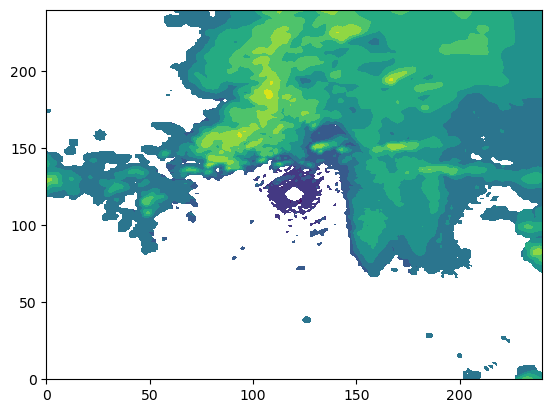

In [8]:
fig, ax = plt.subplots()

ax.contourf(ds10.lon, ds10.lat, ds10.reflectivity[10])

In [6]:
meso_grid10.reflectivity.shape

(75, 3, 4)